# Hate speech identification

The dataset in this notebook is from https://github.com/t-davidson/hate-speech-and-offensive-language

We're going to look at text classification, namely classifying whether tweets contain hate speech or offensive language.

I'm going to use some easy techniques here, LogisticRegression and TfIdfVectorizer from sklearn. I'll look at using character and word based features. We'll also explore what influence various parameters have on classification performance.

In [1]:
import pandas as pd

df = pd.read_csv('twitter-hate-speech.csv', index_col=0)

So data was loaded - let's have a quick look at what's in there?

In [2]:
df.head(n=10)

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just..."
6,3,0,3,0,1,"!!!!!!""@__BrighterDays: I can not just sit up ..."
7,3,0,3,0,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of...
8,3,0,3,0,1,""" &amp; you might not get ya bitch back &amp; ..."
9,3,1,2,0,1,""" @rhythmixx_ :hobbies include: fighting Maria..."


So we have the tweet text and numbers for how many people considered tweets as hate speech or offensive language.

The offensive and hate counts are what we'll try to predict, i will convert those to a binary True/False value.

For the text, we can use TfIdfVectorizer to create numerical features from the text. Basically each word will get assigned a unique feature ID. We can create the textual features based on characters (3-grams) and words, this captures different information because characters keep symbols and punctuation, while words keep the meaning a bit better. 

Character and word based features together should give us the best results - let's see!

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.parsing.preprocessing import preprocess_string
from scipy.sparse import hstack

char_trigrams = TfidfVectorizer(min_df=25, max_df=0.75, strip_accents='ascii', analyzer='char', ngram_range=(3, 3),
                                sublinear_tf=True)

word_unigrams = TfidfVectorizer(min_df=25, max_df=0.75, strip_accents='unicode', analyzer='word',
                                tokenizer=preprocess_string, sublinear_tf=True, stop_words='english')

X_chars = char_trigrams.fit_transform(df['tweet'].values)
X_words = word_unigrams.fit_transform(df['tweet'].values)
X_both = hstack((X_chars, X_words))

y_hate = (df['hate_speech'] >= 1).values
y_offensive = (df['offensive_language'] >= 1).values

Let's look how many features were created?

In [4]:
print(X_chars.shape)
print(X_words.shape)
print(X_both.shape)

(24783, 5657)
(24783, 936)
(24783, 6593)


So we've created our features, now i'm doing some plots of the target variables. What this will show is the strong class imbalance. That's something we should deal with in the models!

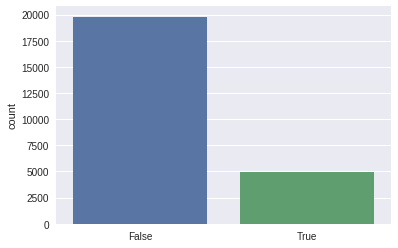

In [5]:
import seaborn as sns
%matplotlib inline

ax = sns.countplot(x=y_hate)

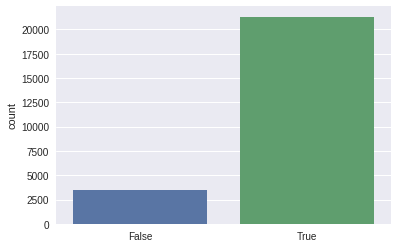

In [6]:
ax = sns.countplot(x=y_offensive)

So now we train and evaluate some basic models on the data - comparing how the model does with character, word and both features. Also comparing performance between hate speech and offensive language.

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression



scores = cross_val_score(LogisticRegression(C=0.25), X_chars, y_hate, cv=5)
print("Score [chars] [is_hate]: {:.4f} (+/- {:.4f})".format(scores.mean(), scores.std()))

scores = cross_val_score(LogisticRegression(C=0.25), X_words, y_hate, cv=5)
print("Score [words] [is_hate]: {:.4f} (+/- {:.4f})".format(scores.mean(), scores.std()))

scores = cross_val_score(LogisticRegression(C=0.25), X_both, y_hate, cv=5)
print("Score [both] [is_hate]: {:.4f} (+/- {:.4f})".format(scores.mean(), scores.std()))



scores = cross_val_score(LogisticRegression(C=0.25), X_chars, y_offensive, cv=5)
print("Score [chars] [is_offensive]: {:.4f} (+/- {:.4f})".format(scores.mean(), scores.std()))

scores = cross_val_score(LogisticRegression(C=0.25), X_words, y_offensive, cv=5)
print("Score [words] [is_offensive]: {:.4f} (+/- {:.4f})".format(scores.mean(), scores.std()))

scores = cross_val_score(LogisticRegression(C=0.25), X_both, y_offensive, cv=5)
print("Score [both] [is_offensive]: {:.4f} (+/- {:.4f})".format(scores.mean(), scores.std()))

Score [chars] [is_hate]: 0.8172 (+/- 0.0037)
Score [words] [is_hate]: 0.8269 (+/- 0.0076)
Score [both] [is_hate]: 0.8294 (+/- 0.0073)
Score [chars] [is_offensive]: 0.8881 (+/- 0.0060)
Score [words] [is_offensive]: 0.9059 (+/- 0.0086)
Score [both] [is_offensive]: 0.9130 (+/- 0.0088)


So the model does a bit better at predicting offensive speech - and you can see how the word and character based features together indeed give best results.

Next we'll do some parameter tuning to optimize performance. We do that twice: Once for hate speech and once for offensive language as they might need different parameters.

I'm using the f1 score as scoring metric to get a balanced view of precision and recall.

In [8]:
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
import numpy as np

gsc = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={
        'C': np.arange(0.01, 1.0, 0.1),
        'class_weight': [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:15}, 'balanced']
    },
    scoring='f1',
    cv=StratifiedShuffleSplit(n_splits=5, test_size=0.2)
)

Now that we've set up parameter tuning, let's look at what the optimal settings are for hate speech and offensive language...

In [9]:
grid_result = gsc.fit(X_both, y_hate)
print("Best score : %.2f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best score : 0.56 using {'C': 0.11, 'class_weight': 'balanced'}


In [10]:
grid_result = gsc.fit(X_both, y_offensive)
print("Best score : %.2f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best score : 0.96 using {'C': 0.91000000000000003, 'class_weight': None}


So we've determine good parameters for the models - let's check how well they clasify the tweets?

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X_both, y_hate, test_size=0.2)

lr = LogisticRegression(C=0.1, class_weight='balanced')
lr.fit(X_train, y_train)

print(classification_report(y_test, lr.predict(X_test)))

             precision    recall  f1-score   support

      False       0.90      0.83      0.87      3948
       True       0.50      0.64      0.56      1009

avg / total       0.82      0.80      0.80      4957



So for hate speech, it's good but not great. Let's look at offensive language?

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_both, y_offensive, test_size=0.2)

lr = LogisticRegression(C=0.8)
lr.fit(X_train, y_train)

print(classification_report(y_test, lr.predict(X_test)))

             precision    recall  f1-score   support

      False       0.77      0.64      0.70       719
       True       0.94      0.97      0.95      4238

avg / total       0.92      0.92      0.92      4957



For offensive language we're doing a bit better it seems